# Partitioning

The system makes use of three different (train, predict) partitioning schemes, used at different points in the process. The three are currently given in the following form:

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}

test_partitioner_dict = {"train":(121,444),"predict":(445,492)}

future_partitioner_dict = {"train":(121,492),"predict":(493,504)}

The numbers are month numbers, defined as number of months since December 1979. 444, then, is December 2015, and 504 December 2021. We change the periods for each of these partitions regularly, typically after an annual update of the most important input data is ready, and, in the case of the future partition, for each monthly update. For calibration and testing purposes, the 'predict' parts are 48 consecutive months.

The number of schemes is due to how VIEWS is training models in multiple stages -- using all data available while avoiding data leakage for the purposes of hyper-parameter tuning (short-hand for procedures for calibration, training model weights, and other hyper-parameter settings), testing of model performance, and future prediction.

The 'calib_partitioner' is used for hyper-parameter tuning for test purposes, the 'test_partitioner' for model training for test purposes as well as for hyper-parameter tuning for future predictions, and the 'future_partitioner' for model training for future predictions. In other words, when we do a run to test the performance of the model system, we do the following:

- train the constituent models on the 'train' part of the calib_partitioner, predict on the 'predict' part of the same, train the hyper-parameters and ensemble weights on these predictions against the actuals in the 'predict' part of this partitioner
- retrain the constituent models with optimized hyper-parameters using the 'train' part of the test_partitioner, predict using the pre-trained ensemble weights for the 'predict' part of the test_partitioner, and evaluate these predictions against the actuals of this predict period.

For future predictions, we retrain all models to make use of all available data:

- train the constituent models on the 'train' part of the test_partitioner, predict on the 'predict' part of the same, train the hyper-parameters and ensemble weights on these predictions against the actuals in the 'predict' part of this partitioner
- retrain the constituent models with optimized hyper-parameters using the 'train' part of the future_partitioner, predict using the pre-trained ensemble weights for the 'predict' part of the future_partitioner. As true future predictions evaluation is not possible until at a later date.

In practice, the use of the partitioner is in fact a bit more involved than this, see the section on 'stepshifting' below.

In [1]:
# Use viewser env

from viewser import Queryset, Column
from ingester3.extensions import *
#from ingester3.DBWriter import DBWriter

import urllib.request
import os

import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [2]:
from pkg_resources import get_distribution
installed_version = get_distribution('ingester3').version

if installed_version >= '1.8.1':
    print (f"You are running version {installed_version} which is consistent with the documentation")
else:
    print (f"""
You are running an obsolete version ({installed_version}). Run:
pip install ingester3 --upgrade 
to upgrade""")

You are running version 1.8.4 which is consistent with the documentation


In [3]:
# Show a list of available transforms
#!viewser transforms list

# Show a list of available transforms
#!viewser tables list

#!viewser tables show priogrid_month

#!viewser tables show priogrid_year

#!viewser tables show country_month

#!viewser tables show country_year

#!viewser tables show ged2_pgm

#!viewser tables show month

#!viewser queryset list

In [4]:
!viewser tables show ged2_pgm


  > Ged2_pgm
  -------------------------------------------------------
  | name                    | path                    |
  |:------------------------|:------------------------|
  | priogrid_month_id       | priogrid_month_id       |
  | ged_sb_best_sum_nokgi   | ged_sb_best_sum_nokgi   |
  | ged_ns_best_sum_nokgi   | ged_ns_best_sum_nokgi   |
  | ged_os_best_sum_nokgi   | ged_os_best_sum_nokgi   |
  | ged_sb_best_count_nokgi | ged_sb_best_count_nokgi |
  | ged_ns_best_count_nokgi | ged_ns_best_count_nokgi |
  | ged_os_best_count_nokgi | ged_os_best_count_nokgi |
  | ged_sb_high_sum_nokgi   | ged_sb_high_sum_nokgi   |
  | ged_ns_high_sum_nokgi   | ged_ns_high_sum_nokgi   |
  | ged_os_high_sum_nokgi   | ged_os_high_sum_nokgi   |
  | ged_sb_high_count_nokgi | ged_sb_high_count_nokgi |
  | ged_ns_high_count_nokgi | ged_ns_high_count_nokgi |
  | ged_os_high_count_nokgi | ged_os_high_count_nokgi |
  
  -------------------------------------------------------



In [5]:
def get_views_date(location, partitioner_dict):

    path_views_data = location + '/views_data.pkl'

    if os.path.isfile(path_views_data) == True:

        print('File already downloaded')
        df = pd.read_pickle(path_views_data)
        
    else:
        print('Beginning file download through viewser...')

        # queryset_base = (Queryset("simon_tests", "priogrid_month")
        #     .with_column(Column("sb_best_count_pgm", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi").transform.ops.ln().transform.missing.replace_na()))

        queryset_base = (Queryset("simon_tests", "priogrid_month")
            .with_column(Column("ln_sb_best", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
            .with_column(Column("ln_ns_best", from_table = "ged2_pgm", from_column = "ged_ns_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
            .with_column(Column("ln_os_best", from_table = "ged2_pgm", from_column = "ged_os_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
            .with_column(Column("month", from_table = "month", from_column = "month"))
            .with_column(Column("year_id", from_table = "country_year", from_column = "year_id"))
            .with_column(Column("c_id", from_table = "country_year", from_column = "country_id")))


        # You want high, and you want ns and os.

        df = queryset_base.publish().fetch()

        df.reset_index(inplace = True)

        df.rename(columns={'priogrid_gid': 'pg_id'}, inplace= True)



        # df = df[df['month_id'] == 121] # temp sub
        # df = df[df['month_id'].isin([121, 122, 123, 124])] # temp sub
        
        
        #month_range = np.arange(partitioner_dict['train'][0],partitioner_dict['predict'][1]+1,1)
        # month_range = np.arange(partitioner_dict['train'][0],partitioner_dict['train'][0]+11,1)
        month_range = np.arange(partitioner_dict['train'][0],partitioner_dict['train'][0]+21,1)


        df = df[df['month_id'].isin(month_range)] # temp sub


        #df['lat'] = df.pg.lat # already in PRIO grid as ycoord
        #df['lon'] = df.pg.lon # already in PRIO grid as xcoord

        #df['month'] = df.pgm.month # See if these can be optained through a query_set
        #df['year_id'] = df.pgm.year # See if these can be optained through a query_set
        #df['row'] = df.pgm.row # already in PRIO grid as row
        #df['col'] = df.pgm.col # already in PRIO grid as col

        #df['c_id'] = df.pgy.c_id # See if these can be optained through a query_set

        df['in_viewser'] = True
        # df['name'] = df.cy.name # No need
#        df.to_pickle(path_views_data)

 #       print('VIEWS data pickled.')

    return df

In [6]:
def get_prio_shape(location):

    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    prio_grid.rename(columns={'gid': 'pg_id'}, inplace= True)

    return prio_grid

In [7]:
def monthly_grid(prio_grid, views_df):

    years = [sorted(views_df['year_id'].unique())] * prio_grid.shape[0]
    #months = [list(np.arange(1, 13))] * prio_grid.shape[0]

    months = [sorted(views_df['month'].unique())] * prio_grid.shape[0] # then you only get one for the test runs# expensive to get these

    prio_grid['year_id'] = years
    prio_grid['month'] = months

    prio_grid = prio_grid.explode('year_id').reset_index(drop=True) 
    prio_grid = prio_grid.explode('month').reset_index(drop=True) 

    prio_grid['year_id'] = prio_grid['year_id'].astype(int)
    prio_grid['month'] = prio_grid['month'].astype(int)

# --------------------

    # # Add month_id - Hack - but likely more robust... and prone to error:
    # prio_grid['year_month'] = prio_grid['year_id'].astype(str) + '_' + prio_grid['month'].astype(str) 

    # ts = prio_grid['year_month'].unique()
    # n_ts = len(ts)
    # month_ids = np.arange(109, n_ts + 109, 1)
    # month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    # prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    # prio_grid.drop(columns=['year_month'], inplace= True)

# ------------------------

    # # Add month_id - Hack, but it works:
    #prio_grid['year_month'] = prio_grid['year'].astype(str) + '_' + prio_grid['month'].astype(str)
    #month_ids = np.arange(views_df['month_id'].min(), views_df['month_id'].max()+1, 1)
    # month_ids = sorted(views_df['month_id'].unique())

    # ts = prio_grid['year_month'].unique()
    # month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    # prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    # Merge
    full_grid = prio_grid.merge(views_df, on = ['pg_id', 'year_id', 'month'], how = 'left')

    full_grid.fillna({'ln_sb_best' : 0, 'ln_ns_best' : 0, 'ln_os_best' : 0, 'c_id' : 0, 'in_viewser' : False}, inplace = True) # for c_id 0 is no country

    #full_grid["month_id"] = full_grid.groupby(["year_id", "month"]).transform(lambda x: x.fillna(x.mean(skipna = True)))['month_id'] # I think this is cool, but must check...
    full_grid["month_id"] = full_grid.groupby(["year_id", "month"]).apply(lambda x: x.fillna(x.mean(skipna = True)))['month_id']


    # Drop stuff..
    full_grid.dropna(inplace=True)
    # the point of this is to drop months that were not give and month_id. The PRIO grid explosion makes only whole years, so this removes any excess months

    return full_grid

In [8]:
def get_sub_grid(grid, views_df):

        views_gids = views_df['pg_id'].unique()

        # get both dim to 180. Fine since you maxpool(2,2) two time: 180 -> 90 -> 45
        # A better number might be 192 since: 192 -> 96 -> 48 -> 24 -> 12 -> 6 -> 3
        max_coords = grid[grid['pg_id'].isin(views_gids)][['xcoord', 'ycoord']].max() + (1,1) 
        min_coords = grid[grid['pg_id'].isin(views_gids)][['xcoord', 'ycoord']].min() - (1,0.25) 
        
        # Maks it
        mask1 = ((grid['xcoord'] < max_coords[0]) & (grid['xcoord'] > min_coords[0]) & (grid['ycoord'] < max_coords[1]) & (grid['ycoord'] > min_coords[1]))
        grid = grid[mask1].copy()

        return grid

In [9]:
def make_volumn(grid):

    # we start with wat we know - but there is no reason not to try with more down til line.

    sub_df = grid[['pg_id', 'xcoord', 'ycoord', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']].copy() # remove the everything also the geo col. What about in_viewser?

    sub_df_sorted = sub_df.sort_values(['month_id', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = sub_df['xcoord'].unique().shape[0]
    y_dim = sub_df['ycoord'].unique().shape[0]
    z_dim = sub_df['month_id'].unique().shape[0]

    ucpd_vol = np.array(sub_df_sorted).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol

In [10]:
def compile():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/number_one/Documents/scripts/conflictNet/data/raw'

    calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}

    test_partitioner_dict = {"train":(121,444),"predict":(445,492)}

    future_partitioner_dict = {"train":(121,492),"predict":(493,504)}

    df = get_views_date(location, calib_partitioner_dict)
    print('done 1')
    grid = get_prio_shape(location)
    print('done 2')
    grid = monthly_grid(grid, df)
    print('done 3')
    grid = get_sub_grid(grid, df)
    print('done 4')
    
    return grid

# Make grid

In [11]:
grid = compile()

Beginning file download through viewser...
 .    done 1
File already downloaded
done 2
done 3
done 4


In [12]:
grid.isna().any()

pg_id         False
xcoord        False
ycoord        False
col           False
row           False
year_id       False
month         False
month_id      False
c_id          False
ln_sb_best    False
ln_ns_best    False
ln_os_best    False
in_viewser    False
dtype: bool

In [13]:
grid['month_id'].unique()

array([121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141.])

In [14]:
print(len(grid['xcoord'].unique()))
print(len(grid['ycoord'].unique()))

180
180


In [15]:
grid.head()

,pg_id,xcoord,ycoord,col,row,year_id,month,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best,in_viewser
1629240,191288,63.75,42.75,488,266,1990,1,121.0,0.0,0.0,0.0,0.0,False
1629241,191288,63.75,42.75,488,266,1990,2,122.0,0.0,0.0,0.0,0.0,False
1629242,191288,63.75,42.75,488,266,1990,3,123.0,0.0,0.0,0.0,0.0,False
1629243,191288,63.75,42.75,488,266,1990,4,124.0,0.0,0.0,0.0,0.0,False
1629244,191288,63.75,42.75,488,266,1990,5,125.0,0.0,0.0,0.0,0.0,False


In [16]:
(grid['ln_sb_high'] == grid['ln_sb_best']).mean() 

KeyError: 'ln_sb_high'

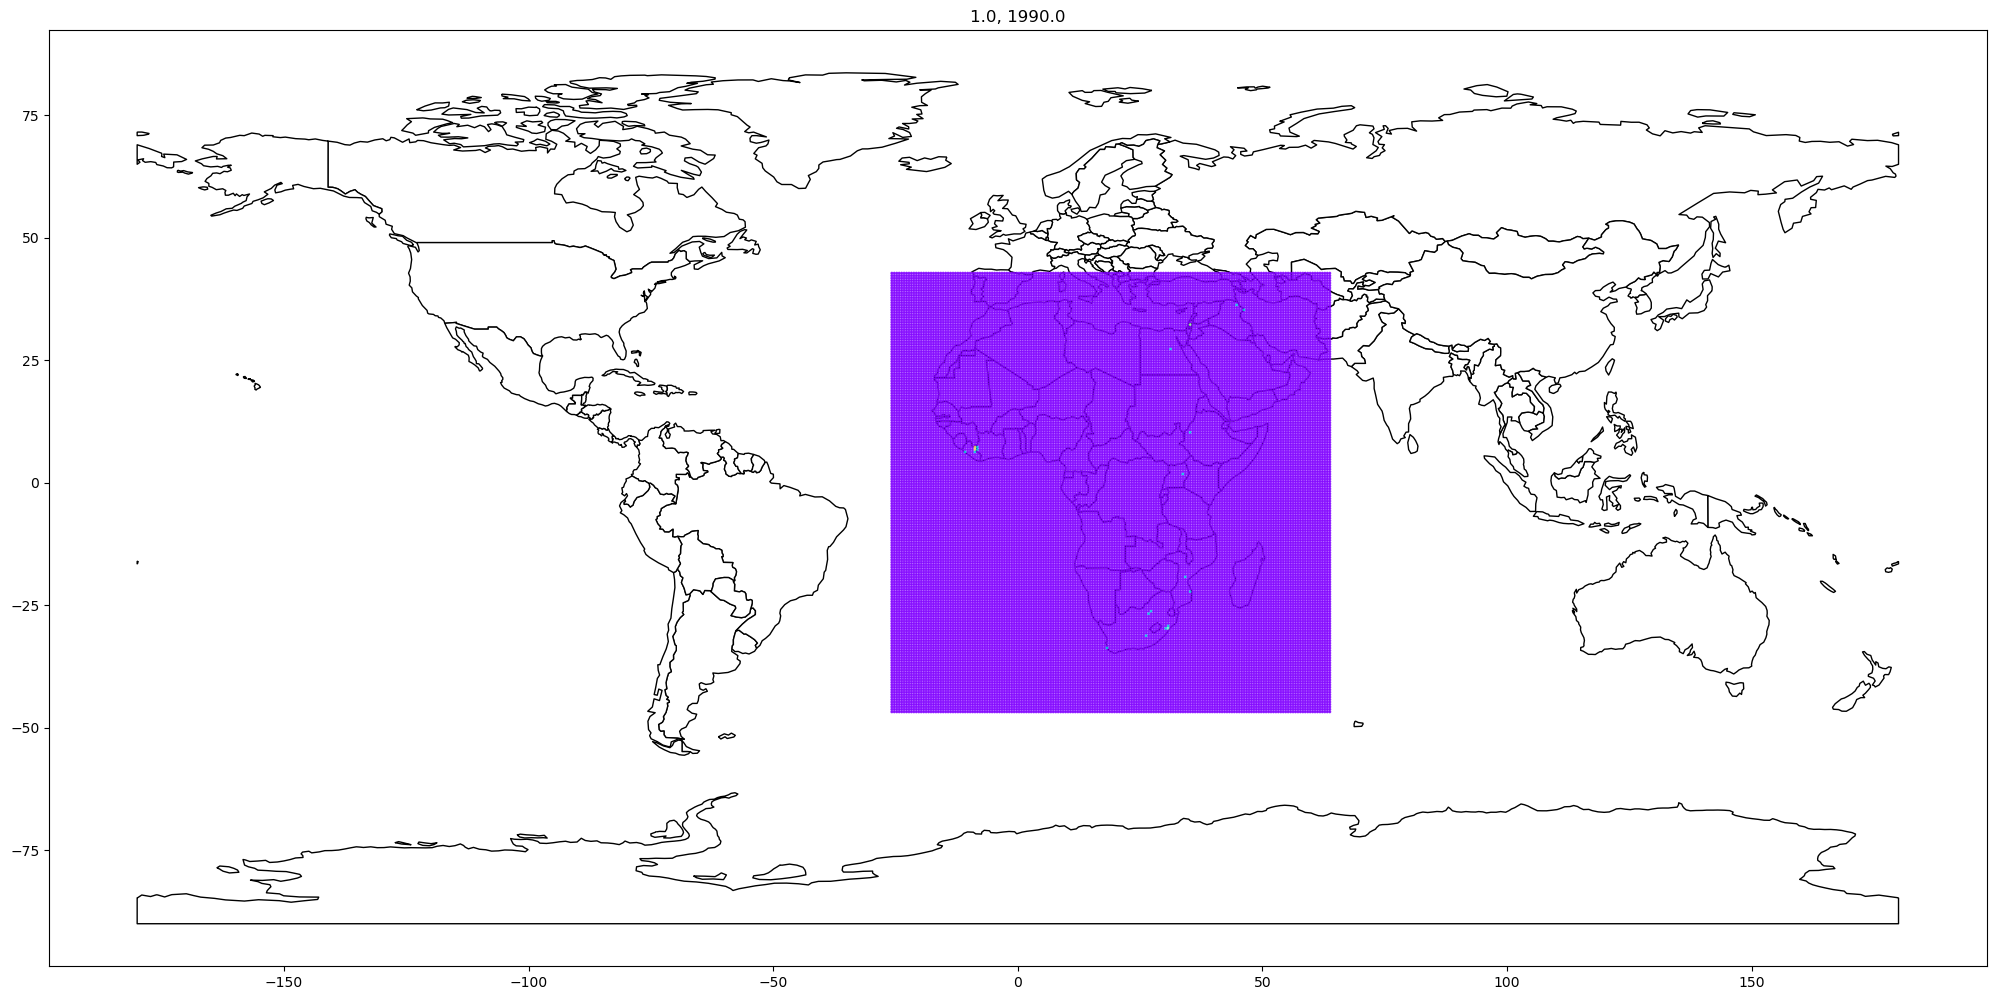

In [ ]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_os_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

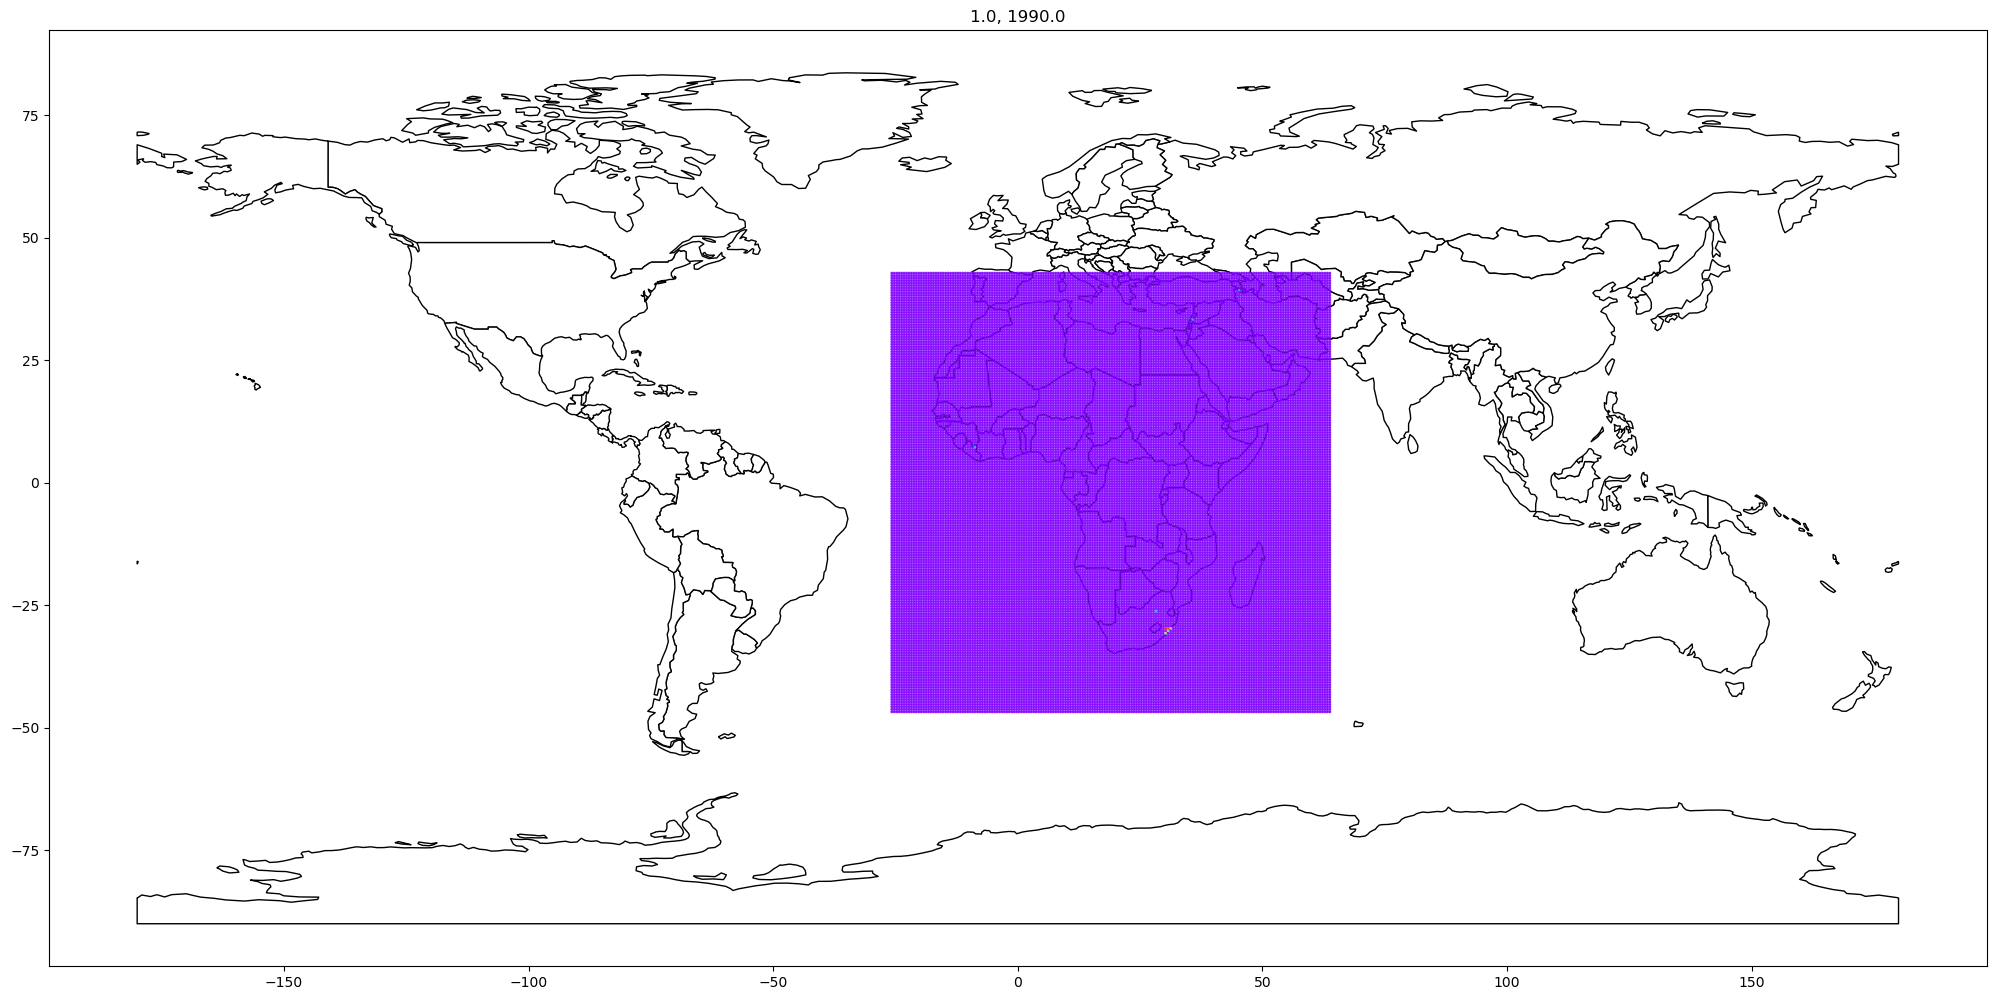

In [ ]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_ns_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

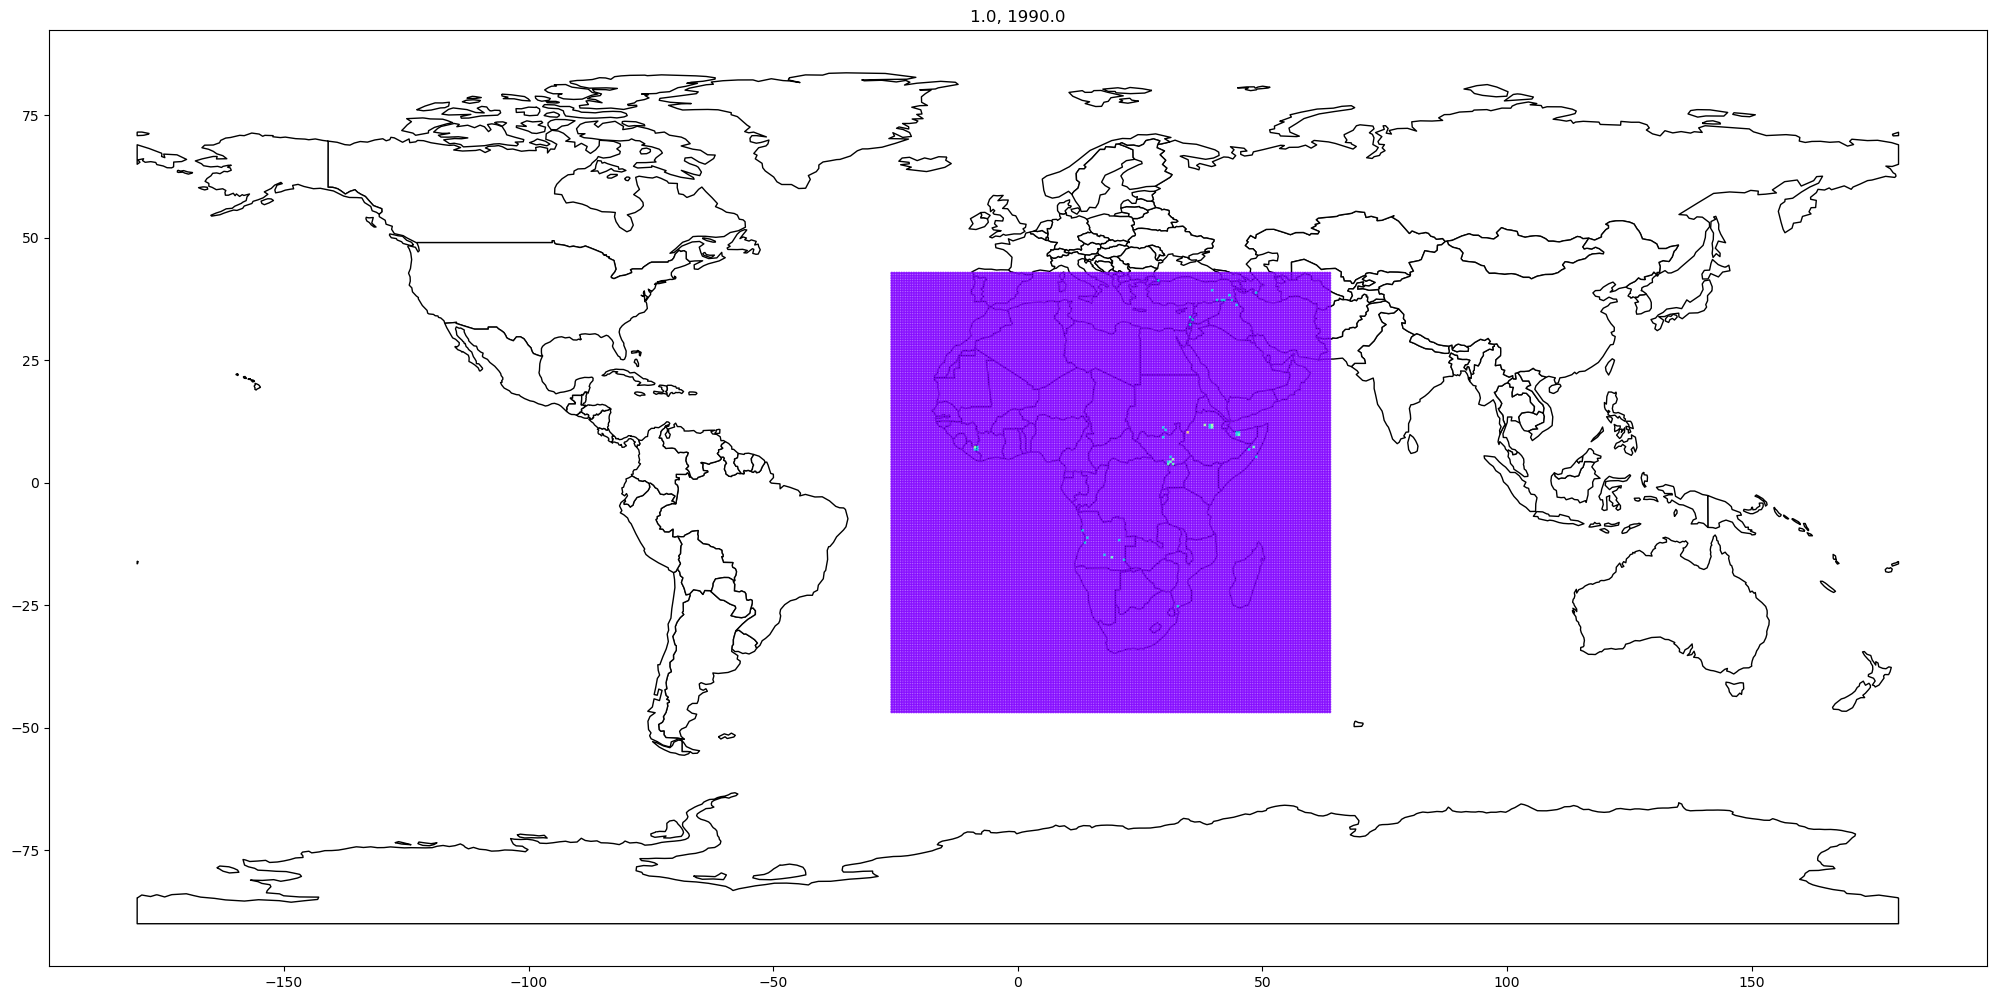

In [ ]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_sb_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

# Make volumn

In [ ]:
grid.shape

(680400, 13)

In [ ]:
grid.isna().any()

pg_id         False
xcoord        False
ycoord        False
col           False
row           False
year_id       False
month         False
month_id      False
c_id          False
ln_sb_best    False
ln_ns_best    False
ln_os_best    False
in_viewser    False
dtype: bool

In [ ]:
grid[grid['month_id'].isna()]['month'].unique()

array([], dtype=int64)

In [ ]:
grid[grid['month_id'].isna()]['year_id'].unique()

array([], dtype=int64)

In [ ]:
vol = make_volumn(grid)

In [ ]:
vol.shape

(21, 180, 180, 8)

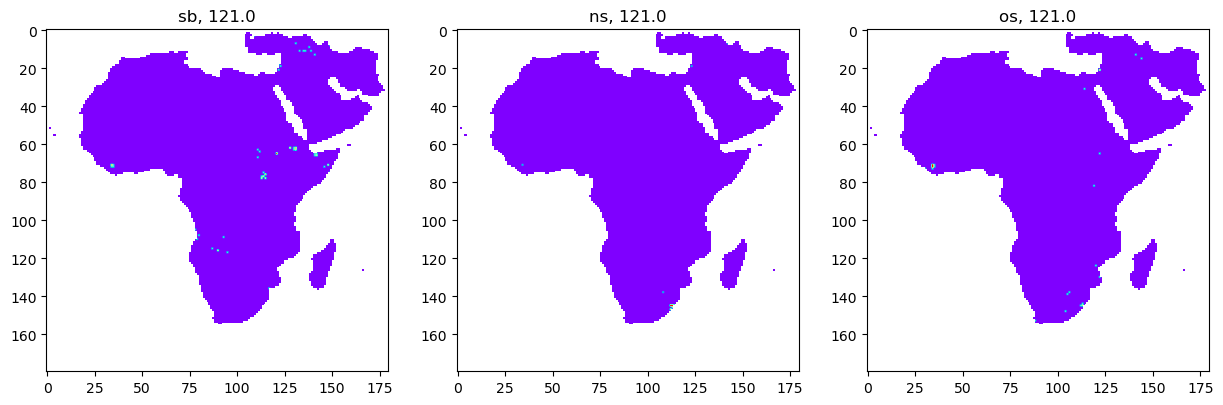

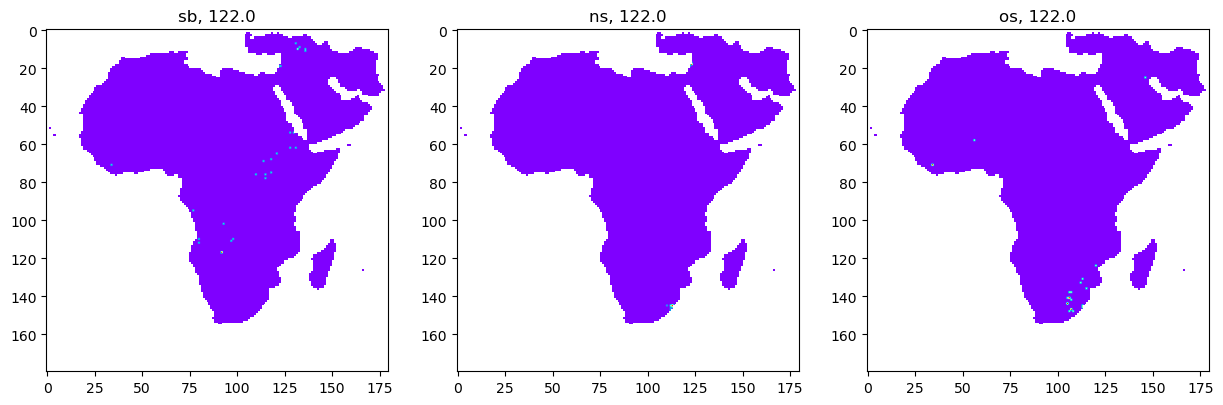

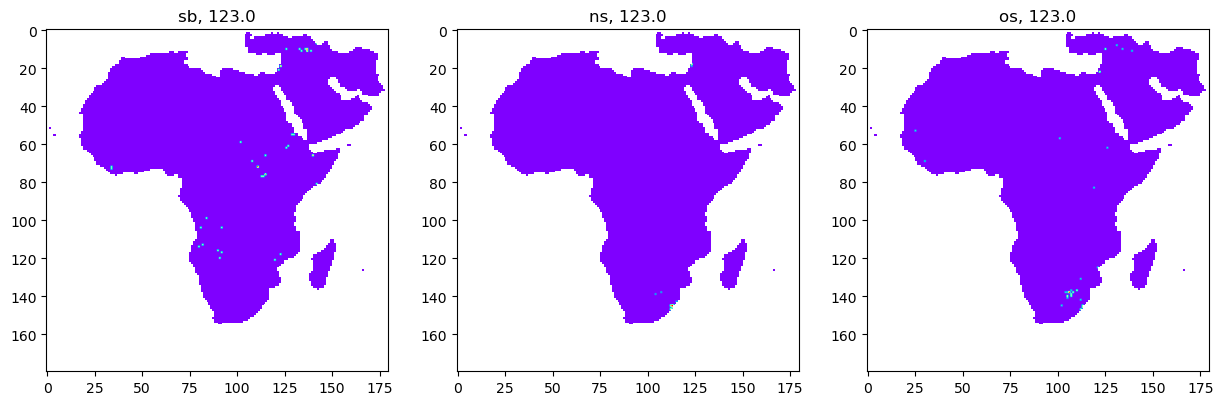

In [ ]:
for i in range(3): #vol.shape[0]):

    fig, axs  = plt.subplots(1,3, figsize= (15,15))

    month = vol[i,:,:,3].mean()

    true_sb_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,5])
    axs[0].imshow(true_sb_masked, cmap = 'rainbow')
    axs[0].set_title(f"sb, {month}")
    
    true_ns_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,6])
    axs[1].imshow(true_ns_masked, cmap = 'rainbow')
    axs[1].set_title(f"ns, {month}")
    
    true_os_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,7])
    axs[2].imshow(true_os_masked, cmap = 'rainbow')
    axs[2].set_title(f"os, {month}")

    plt.show()